In [1]:
import h5py
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pointCollection as pc

In [2]:
N_max={'weak':57./2.*10.*3., 'strong':57./2.*10.*12.}
#print(N_max)
spot_max={spot:N_max['weak'] for spot in [2, 4, 6]}
spot_max.update({spot:N_max['strong'] for spot in [1, 3, 5]})
print(spot_max)

{2: 855.0, 4: 855.0, 6: 855.0, 1: 3420.0, 3: 3420.0, 5: 3420.0}


Here's a function to read a residual histogram from an ATL06 file.  

In [5]:
def read_one_hist(thefile, spot_max):

    IPF={}
    IPF_sigma={}
    Nbar={}
    Ntot={}
    bins=None
    zbin=None
    z=None
    with h5py.File(thefile,'r') as h5f:
        for pair in ['1', '2', '3']:
            for lr in ['l','r']:
                ds=f'gt{pair}{lr}'
                try:
                    if bins is None:
                        bth=np.array(h5f['/gt1l/residual_histogram']['bin_top_h'])
                        bin_w=np.zeros_like(bth)
                        bin_w[1:]=np.diff(bth)
                        bin_w[0] = 1
                        zbin=bth-bin_w/2
                        bins=np.abs(zbin)<5
                        z=zbin[bins]
                    spot=np.float64(h5f[ds].attrs['atlas_spot_number'])
                    N=np.array(h5f[f'/{ds}/residual_histogram']['count']).astype(float)
                    N[N>10000]=0
                    Ntot[spot]=np.nansum(N[:,bins], axis=1)
                    good=Ntot[spot] > spot_max[int(spot)]/4
                    Ntot[spot]=Ntot[spot][good]
                    Nbar[spot] = np.nanmean(N[good,:][:,bins], axis=0)
                    IPF[spot] = Nbar[spot] / bin_w[bins]
                    IPF_sigma[spot] = np.sqrt(np.nansum(N[good,:][:,bins], axis=0))/(np.sum(bins)*bin_w[bins])
                    
                except Exception:
                    pass
                
    return z, Ntot, Nbar, IPF, IPF_sigma
            

I've also written a function to do this and to save the results in an hdf5 file, in collect_mean_res_hist.py.  This function is designed to be run in parallel for a whole directory of ATL06es, and I've done so for all the ATL06es on css.  The results are below.

In [6]:
out_dir='/home/besmith4/nobackup/ATL06_res_hist/'
save_files = glob.glob(out_dir+'/*.h5')
print(save_files[1])
D_template=pc.data().from_h5(save_files[1], group='spot_2')

/home/besmith4/nobackup/ATL06_res_hist/ATL06_20200619151436_12990711_003_01_rh_avg.h5


As it turns out, the first file processed is pretty ordinary.  Here's what it looks like:

Text(0, 0.5, '$\\delta$ h, m')

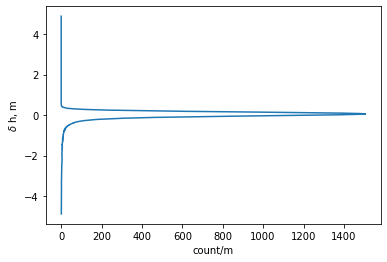

In [7]:
plt.figure()
plt.plot(D_template.P, D_template.z)
plt.gca().set_xlabel('count/m')
plt.gca().set_ylabel('$\delta$ h, m')

The 2819th file has a problem: there's a lobe of extra energy at ~1.5-2 m.  Here's what it looks like:

Text(0, 0.5, '$\\delta$ h, m')

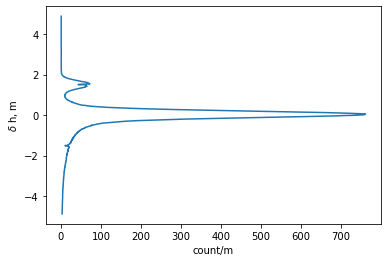

In [8]:
#[2819 3550]
D_problem=pc.data().from_h5(save_files[2819], group='spot_2')
plt.figure()
plt.plot(D_problem.P, D_problem.z)
plt.gca().set_xlabel('count/m')
plt.gca().set_ylabel('$\delta$ h, m')

Now let's read in all the histograms from all the saved files, and make some plots.  This takes make-a-cup-of-coffee-and-drink-it.  You might get a sandwich too.

In [ ]:
out_dir='/home/besmith4/nobackup/ATL06_res_hist/'
save_files = glob.glob(out_dir+'/*.h5')
print(len(save_files))
D_template=pc.data().from_h5(save_files[1], group='spot_1')

spots=range(1,7)
Nbar={spot: np.zeros([D_template.z.size, len(save_files)])+np.NaN for spot in spots}
P={spot: np.zeros([D_template.z.size, len(save_files)])+np.NaN for spot in spots}
P_sigma={spot: np.zeros([D_template.z.size, len(save_files)])+np.NaN for spot in spots}
for ii, file in enumerate(save_files):
    if np.mod(ii, 200)==0:
        print(ii)
    for spot in spots:
        try:
            temp=pc.data().from_h5(file, group=f'spot_{spot}')
            Nbar[spot][:, ii] = temp.Nbar
            P[spot][:, ii] = temp.P
            P_sigma[spot][:, ii] = temp.P_sigma            
        except Exception as e:
            pass


As we saw above, the range between 1.25 and 2 m above the surface can contain the TEP peak.  Adding up these bins can also catch some surface broadening, so to avoid false triggers on noisy returns, it's worthwhile to subtract the negative mirror of that bin range.

In [ ]:
lobe_bins = (D_template.z > 1.25) & (D_template.z < 2)
minus_lobe_bins = (D_template.z > -2) & (D_template.z < -1.25)

Let's look at the difference in power between the positive and negative lobe bins.  If this difference is large and positive, it indicates power in the upper lobe.  If it's negative, that's probably a sign of foward scattering.

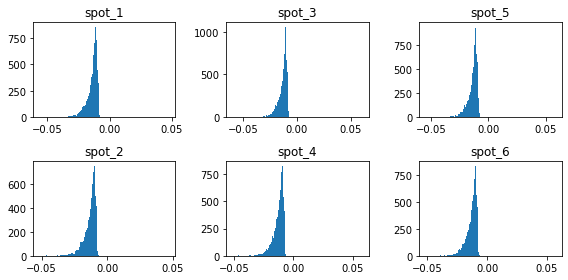

In [11]:
f_lobe = {spot: (np.sum(Nbar[spot][lobe_bins], axis=0) - np.sum(Nbar[spot][minus_lobe_bins], axis=0))/np.sum(Nbar[spot], axis=0) for spot in spots}
fig=plt.figure(figsize=[8,4]); 
hax=fig.subplots(2, 3).T.ravel()
for spot in spots:
    hax[spot-1].hist(f_lobe[spot], 200);
    hax[spot-1].set_title(f'spot_{spot}');
plt.tight_layout()

Note that all of the scales extend to +0.05: this indicates that there are some histogram bins that contain some (but very few elements) at this position.

We can look for problems that are correlated by PCE card by plotting the lobe differences for the two spots on each PCE against each other:

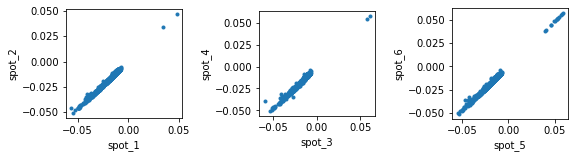

In [13]:
fig=plt.figure(figsize=[8,3]); 
ax=fig.subplots(1, 3)
for s0 in [1,3,5]:
    ax[int(s0/2-0.5)].plot(f_lobe[s0], f_lobe[s0+1],'.')
    ax[int(s0/2-0.5)].set_aspect('equal')
    ax[int(s0/2-0.5)].set_xlabel(f'spot_{s0}')
    ax[int(s0/2-0.5)].set_ylabel(f'spot_{s0+1}')

fig.tight_layout()

The clusters of points in the upper left-hand part of the plot indicate extra energy in the lobes. Let's make a list of the problems and plot the affected returns:

SPOTS: (1, 2)
ATL06_20200511161217_07040711_003_01.h5
ATL06_20200511174635_07050711_003_01.h5
SPOTS: (3, 4)
ATL06_20200730180833_05400811_003_01.h5
ATL06_20200731002542_05440811_003_01.h5
SPOTS: (5, 6)
ATL06_20200405203547_01570711_003_01.h5
ATL06_20200405221004_01580711_003_01.h5
ATL06_20200411180152_02470711_003_01.h5
ATL06_20200411193609_02480711_003_01.h5
ATL06_20200411211027_02490711_003_01.h5
ATL06_20200420154517_03830711_003_01.h5
ATL06_20200420171935_03840711_003_01.h5
ATL06_20200420185352_03850711_003_01.h5
ATL06_20200420202810_03860711_003_01.h5
ATL06_20200420220227_03870711_003_01.h5
ATL06_20200424153659_04440711_003_02.h5
ATL06_20200609175652_11480711_003_01.h5
ATL06_20200609193109_11490711_003_01.h5
ATL06_20200609210527_11500711_003_01.h5


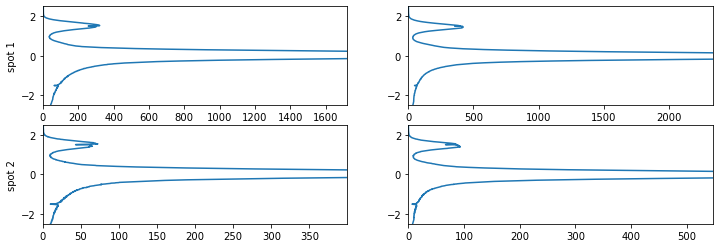

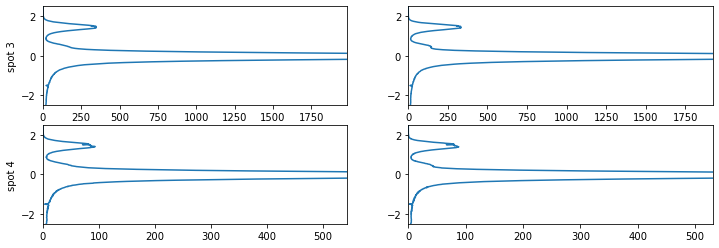

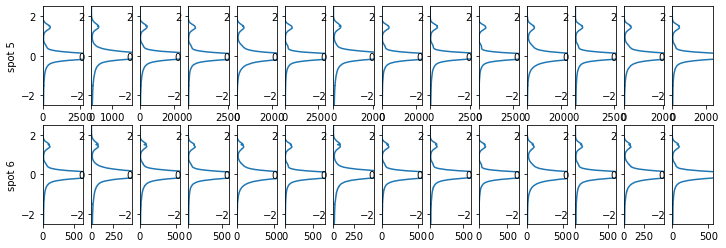

In [14]:
problem_files={}
for spot0 in [1, 3, 5]:
    check_spots=(spot0,spot0+1)

    these=np.flatnonzero((f_lobe[check_spots[0]] > 0.015) & (f_lobe[check_spots[1]]> 0.015))
    #print(these.nonzero())
    print(f'SPOTS: {check_spots}')
    fig=plt.figure(figsize=[12, 4])
    hax=fig.subplots(2, len(these))
    for count, ii in enumerate(these):
        hax[0,count].plot(P[check_spots[0]][:, ii], D_template.z)
        hax[1,count].plot(P[check_spots[1]][:, ii], D_template.z)
    hax[0, 0].set_ylabel(f'spot {check_spots[0]}')
    hax[1, 0].set_ylabel(f'spot {check_spots[1]}')
    for ax in hax.ravel():
        ax.set_xlim([0, ax.get_xlim()[1]/2])
        ax.set_ylim([-2.5, 2.5])
    problem_files[check_spots]=[]
    for ii in these:
        problem_files[check_spots] += [os.path.basename(save_files[ii]).replace('_rh_avg','')]
    problem_files[check_spots].sort()
    [print(ii) for ii in problem_files[check_spots]];


We can do the same thing by looking at the position of the main peak.  Let's look at the centroid of the histogram that's stronger than 38% of the peak energy:

In [15]:
def calc_z38(P, N, z):
    zbar=np.zeros(N.shape[1])
    for col in range(N.shape[1]):
        N1=N[:,col]
        ii=P[:,col] > 0.38*P[:,col].max()
        zbar[col]=np.sum(z[ii]*N1[ii])/N1[ii].sum()
    return zbar

In [16]:
z=D_template.z
z38={}
z38={spot:calc_z38(P[spot], Nbar[spot], z) for spot in spots}

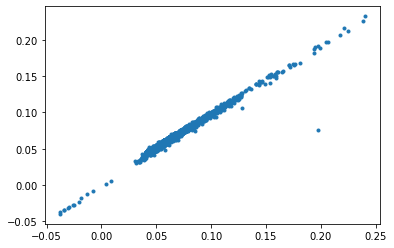

In [30]:
plt.figure(); plt.plot(z38[5], z38[6],'.')

[1257 1292 1413 2251 2458 3106 4045 5016 5966 7203 8588 8821 8967 9090]


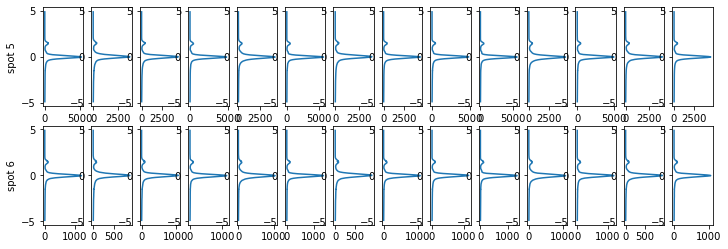

In [31]:
check_spots=(5,6)
these=np.flatnonzero(((z38[check_spots[0]]<0.025) & (z38[check_spots[1]] < 0.025)))
print(these)
if True:
    fig=plt.figure(figsize=[12, 4])
    hax=fig.subplots(2, np.maximum(len(these),2))
    for count, ii in enumerate(these):
        hax[0,count].plot(P[check_spots[0]][:, ii], D_template.z)
        hax[1,count].plot(P[check_spots[1]][:, ii], D_template.z)
    hax[0, 0].set_ylabel(f'spot {check_spots[0]}')
    hax[1, 0].set_ylabel(f'spot {check_spots[1]}')

So what are all those points in the other direction (on the upper-right side of the plot)?

[3519 5371 6284 8007 8292]


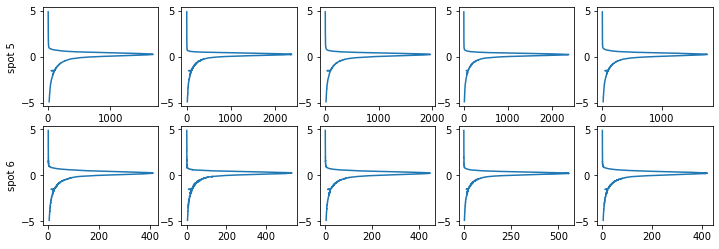

In [32]:
check_spots=(5,6)
these=np.flatnonzero(((z38[check_spots[0]]>.2) & (z38[check_spots[1]] >.2)))
print(these)
if True:
    fig=plt.figure(figsize=[12, 4])
    hax=fig.subplots(2, np.maximum(len(these),2))
    for count, ii in enumerate(these):
        hax[0,count].plot(P[check_spots[0]][:, ii], D_template.z)
        hax[1,count].plot(P[check_spots[1]][:, ii], D_template.z)
    hax[0, 0].set_ylabel(f'spot {check_spots[0]}')
    hax[1, 0].set_ylabel(f'spot {check_spots[1]}')

Looks like those are caused by forward scattering.

In [ ]:
! pwd